In [1]:
import glob
import numpy as np
import os.path
import math
from math import sqrt,pi
import matplotlib.pyplot as plt
import mpmath as mp
%matplotlib inline
from scipy import special
mydehoog = mp.calculus.inverselaplace.deHoog(mp)

L=5
#L=6.5
f=1.0208582

Ns=[2010,2017] 
Ns=[251,252]
#Ns=[252,252]
Ns=[423,423]
Ns=[753,756]
#conc=10#10,30,80
actualA = [25.1282,25.2217]
#actualA = [25.2217,25.2217]
#actualA=[42.3799,42.3799]

def calk(stsim,t,C): #get kt from st
    dst = (stsim[2:]-stsim[:-2])/(t[2:]-t[:-2])
    dst=np.append((stsim[1]-stsim[0])/(t[1]-t[0]),dst)
    dst=np.append(dst,(stsim[-1]-stsim[-2])/(t[-1]-t[-2])  )
    return -dst/stsim/C


In [7]:
import glob
import numpy as np
import os.path
import math
from math import sqrt,pi
import matplotlib.pyplot as plt
import mpmath as mp
%matplotlib inline
from scipy import special
mydehoog = mp.calculus.inverselaplace.deHoog(mp)
from scipy.integrate import cumtrapz

kaf=100
R=0.01
D=1
ka=kaf*D*4*pi
f=1.0208582
Ns=756
actualA=25.#2217

g=0.577216;
f = 1.0208582;
Pa=1./(1+(3)**0.5*(math.log(f*f/12)+(4*pi*D/ka)-2*g)/2/pi);
l=f*R
tdl = l*l/4/D

conc = Ns/actualA
td = R*R/4/D
dt = td/100
tmax = 0.13#td*1000
tt = np.arange(dt,tmax+dt,dt)

In [8]:
dps = 8
def invlt(ka,R,D,t):    #inverse laplace transform of k(z)
    C=R/D**0.5
    mp.dps = dps#15;
    kz = lambda s: 2*np.pi*D*C*special.kv(1,C*(complex(s)**0.5))/complex(s)**0.5/special.kv(0,C*(complex(s)**0.5)) 
    fp= lambda s: ka/(complex(s)+ka/kz(s))
    t = mp.convert(t)
    mydehoog.calc_laplace_parameter(t)
    fpvec = [fp(p) for p in mydehoog.p]
    ft =(float(mydehoog.calc_time_domain_solution(fpvec,t,manual_prec=True)))
    return ft

kte = np.array([invlt(ka,R,D,t) for t in tt])
dt = tt[1]-tt[0]
Sthe = np.exp(-conc*dt*cumtrapz(kte,initial=0))
#tth = tt[(subd-1)::subd]

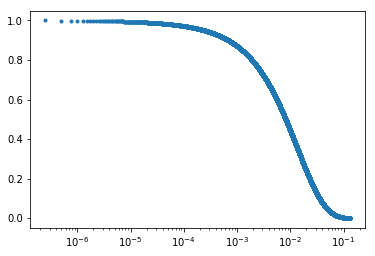

In [9]:
plt.semilogx(tt,Sthe,'.')
name = '/home/chew/outputdata/keff/2D/Cont_kfac100_N756_L5_A25_rm0.005_meanst'
filename=open(name,'w')
np.savetxt(name,[tt,Sthe],delimiter=',',fmt='%s')
filename.close()            

In [161]:
from mpmath import ellipk
def latK(s,D,Pa,td,ka):
    b1 = Pa/6/td;
    b2 = 1/td;
    p101 = 1/6; 
    zz = b2/(b2+s);
    a = 3/zz+1-(3+6/zz)**0.5;
    b = 3/zz+1+(3+6/zz)**0.5;
    c = (a+1)*(b-1);
    kk = 2*(b-a)/c
    EF = ellipk(kk);
    Pz = 6*EF/pi/zz/(c)**0.5;
    f11 = 1-zz*zz*p101/(Pz-1);
    g = b1/(s+b1+b2-s*zz/3-b2*f11);
    return 2*Pa*D*3**0.5*(1-g)/s;

def invltL(t,D,Pa,td,ka): #inverse laplace transform of lattice k(s)
    mp.dps = dps#15;
    t = mp.convert(t)
    mydehoog.calc_laplace_parameter(t)
    fpvec = [latK(p,D,Pa,td,ka) for p in mydehoog.p]
    ft =(float(mydehoog.calc_time_domain_solution(fpvec,t,manual_prec=True)))
    return ft

ktL = np.array([invltL(t,D,Pa,td,ka) for t in tt])
dt = tt[1]-tt[0]
SthL = np.exp(-conc*dt*cumtrapz(ktL,initial=0))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0,0.5,'S_lat-S_cont')

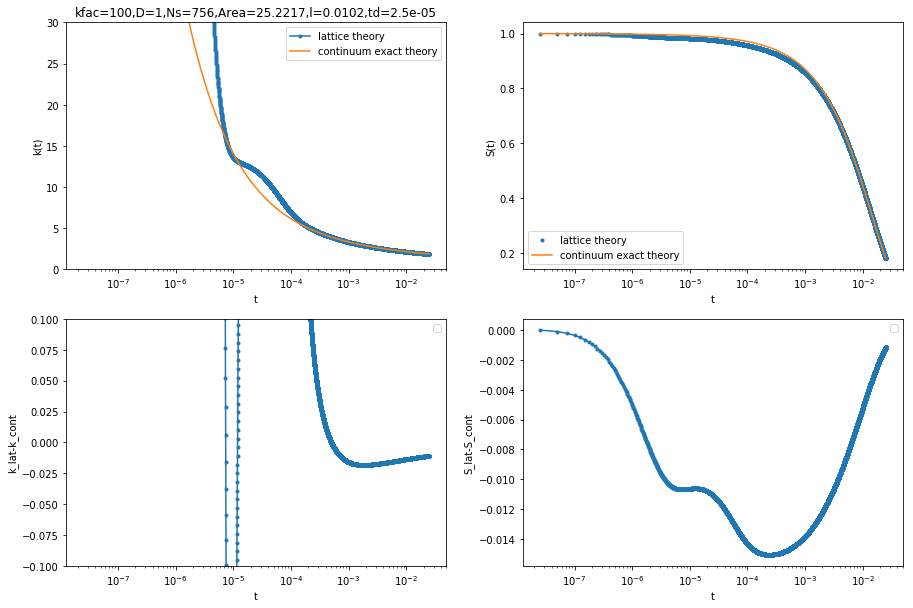

In [165]:
kdiff = ktL-kte
Sdiff = SthL-Sthe
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax[0][0].plot(tt,ktL,'.-',label='lattice theory')
ax[0][0].set_title('kfac={},D={},Ns={},Area={},l={:.4f},td={}'.format(kaf,D,Ns,actualA,l,td))
ax[0][0].semilogx(tt,kte,'-',label='continuum exact theory')
ax[0][0].set_ylim(0,30)
ax[0][0].set_xlabel('t')
ax[0][0].legend()
ax[0][0].set_ylabel('k(t)')

ax[0][1].plot(tt,SthL,'.',label='lattice theory')
ax[0][1].semilogx(tt,Sthe,'-',label='continuum exact theory')
ax[0][1].legend()
ax[0][1].set_xlabel('t')
ax[0][1].set_ylabel('S(t)')

ax[1][0].semilogx(tt,kdiff,'.-')
ax[1][0].set_xlabel('t')
ax[1][0].legend()
ax[1][0].set_ylim(-0.1,0.1)
ax[1][0].set_ylabel('k_lat-k_cont')

ax[1][1].semilogx(tt,Sdiff,'.-')
ax[1][1].set_xlabel('t')
ax[1][1].legend()
#ax[1][1].set_ylim(-5,5)
ax[1][1].set_ylabel('S_lat-S_cont')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0,0.5,'(S_lat-S_cont)*100/S_lat')

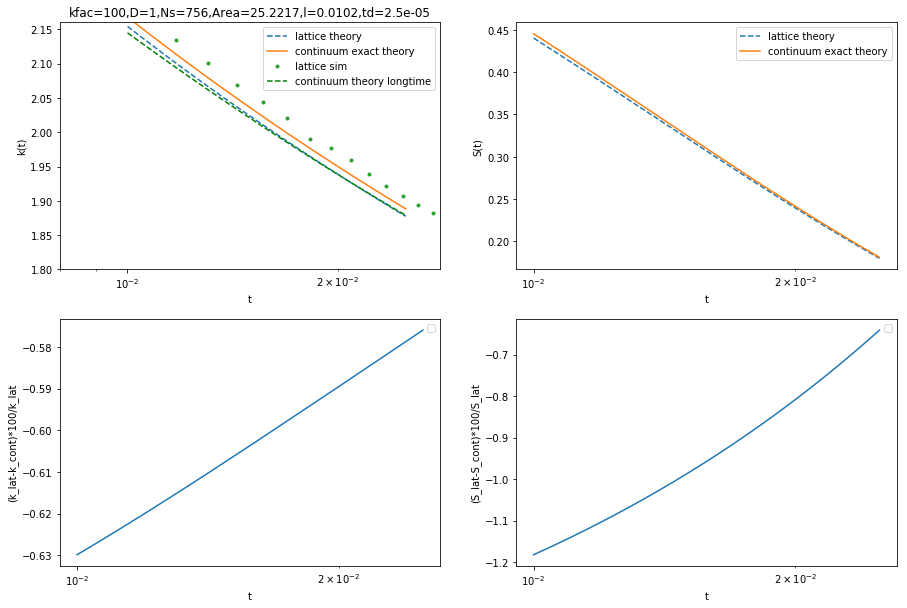

In [180]:
g = 0.577216
def func(t,C1,C2): #lattice kt for long time
    b1=4*D/C2/C2
    A=np.log(b1*t)+4*pi*D/C1-2*g
    return 4*pi*D*(1/A-g/A**2+(g**2-np.pi**2/6)/A**3+0.25/A**4)

idx=[tt>1e-2]
xx = tt[idx]
kl = ktL[idx]
ke = kte[idx]
sl = SthL[idx]
se = Sthe[idx]
kdiff = (kl-ke)*100/kl
Sdiff = (sl-se)*100/sl
fig,ax = plt.subplots(2,2,figsize=(15,10))
ax[0][0].plot(xx,kl,'--',label='lattice theory')
ax[0][0].set_title('kfac={},D={},Ns={},Area={},l={:.4f},td={}'.format(kaf,D,Ns,actualA,l,td))
ax[0][0].semilogx(xx,ke,'-',label='continuum exact theory')
ax[0][0].set_ylim(1.8,2.16)
ax[0][0].set_xlim(0.8e-2,2.8e-2)
ax[0][0].set_xlabel('t')
ax[0][0].set_ylabel('k(t)')
ax[0][0].semilogx(T,ktsim,'.',label='lattice sim')
ax[0][0].semilogx(xx,func(xx,ka,R),'g--',label='continuum theory longtime')
ax[0][0].legend()



ax[0][1].plot(xx,sl,'--',label='lattice theory')
ax[0][1].semilogx(xx,se,'-',label='continuum exact theory')
ax[0][1].legend()
ax[0][1].set_xlabel('t')
ax[0][1].set_ylabel('S(t)')

ax[1][0].semilogx(xx,kdiff,'-')
ax[1][0].set_xlabel('t')
ax[1][0].legend()
#ax[1][0].set_ylim(-0.1,0.1)
ax[1][0].set_ylabel('(k_lat-k_cont)*100/k_lat')

ax[1][1].semilogx(xx,Sdiff,'-')
ax[1][1].set_xlabel('t')
ax[1][1].legend()
#ax[1][1].set_ylim(-5,5)
ax[1][1].set_ylabel('(S_lat-S_cont)*100/S_lat')

In [130]:
#np.set_printoptions(8)
kaf=100
R=0.005
D=1
ka=kaf*D*4*pi
L=6.5
f=1.0208582
Ns=[423,423]
actualA=[42.3799,42.3799]

patterns3 = ['/home/chew/outputdata/keff/2D/orikfac{}_N{}_L{}_50tm_{}rm/*'.format(kaf,Ns[1],L,f),
             '/home/chew/outputdata/keff/2D/newkfac{}_N{}_L{}_50tm_{}rm/*'.format(kaf,Ns[1],L,f)]

def err(a,b):
    return (a-b)*100/a
    #return (a-b)

time=[]
St=[]

for i,pattern in enumerate(patterns3):
    N=Ns[i]
    Area=actualA[i]
    conc = N/Area    
    print(pattern)
    print('N{},Area{}'.format(N,Area))
    fns = glob.glob(pattern)
    fns=fns[:500]
    kts = []
    ss=[]
    ds = 1
    cnter = 0
    for fn in fns:
        r=np.loadtxt(fn,delimiter=',')
        y=np.array(r).T[1][::ds]
        s=y/float(N)   
        ss.append(s)
        cnter+=1
    x=np.array(r).T[0][::ds]
    s=np.mean(np.array(ss),axis=0)
    #mkt=calk(s,x,conc)[1:]
    x=x[1:]
    #print(x[:5])
    print(x[-5:])  
    #print(tth[:5])
    print(tth[-5:])      
    s=s[1:]
    
    St.append(s)
    time.append(x)


/home/chew/outputdata/keff/2D/orikfac100_N423_L6.5_50tm_1.0208582rm/*
N423,Area42.3799
[0.19410071 0.1954034  0.19670609 0.19800878 0.19931147]
[0.19410071 0.1954034  0.19670609 0.19800878 0.19931147]
/home/chew/outputdata/keff/2D/newkfac100_N423_L6.5_50tm_1.0208582rm/*
N423,Area42.3799
[0.19410071 0.1954034  0.19670609 0.19800878 0.19931147]
[0.19410071 0.1954034  0.19670609 0.19800878 0.19931147]


0.00130268933063404976
[0.94816668 0.91283746 0.88208366 0.85412984 0.82821664]


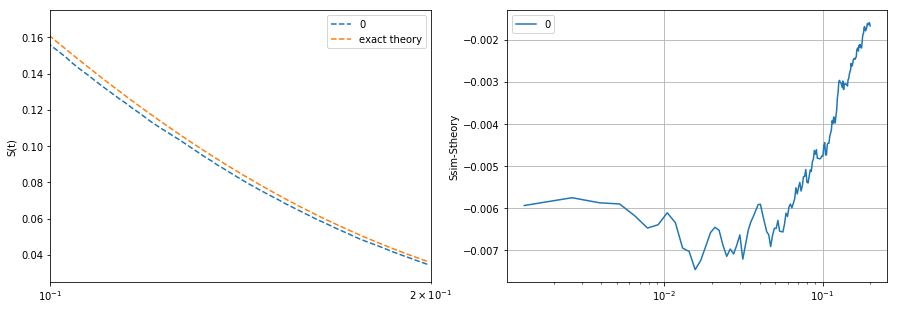

In [163]:
from scipy.integrate import cumtrapz
tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr100N423A42_3799.csv',delimiter=',').T
tth = tth[99::100]
Sth = Sth[99::100]
#subd=100
dt = (x[1]-x[0])
print('{:.20f}'.format(dt))
#tt = np.arange(dt,x[-1]+dt,dt)
#kt = invlt(ka,x)
#kt = np.array([invlt(ka,t) for t in tt])
#dt = x[1]-x[0]
#Sth = np.exp(-conc*dt*cumtrapz(kt,initial=0))[(subd-1)::subd]
#tth = tt[(subd-1)::subd]

fig,ax=plt.subplots(1,2,figsize=(15,5))
for i in range(1):
    N=Ns[i]
    Area=actualA[i]
    conc = N/Area   
    x=time[i]
    s=St[i]
    print(Sth[:5])
    ax[0].semilogx(x,s,'--',label=str(i))
    ax[0].semilogx(tth,Sth,'--',label='exact theory')
    #diff = err(s,Sth)
    diff=s-Sth
    ax[1].semilogx(tth,diff,label=str(i))
    #ax[0].semilogx(tth,Sth,'r')
ax[0].set_xlim(0.1,0.2)
ax[0].set_ylim(0.025,0.175)
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Ssim-Stheory')
ax[1].grid(True)
ax[1].legend()
ax[0].legend()

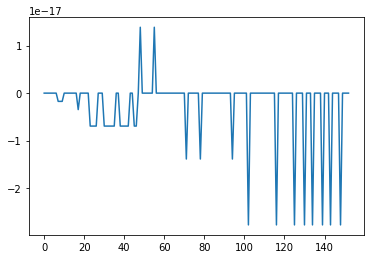

In [158]:
tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr100N423A42_3799.csv',delimiter=',').T
#tth = tth[99::100]
subd=100
dt = (x[1]-x[0])/subd
tt = np.arange(dt,x[-1]+dt,dt)[(subd-1)::subd]
plt.plot(tt-x)

/home/chew/outputdata/keff/2D/orikfac100_N756_L5_50tm_1.0208582rm/*
N756,Area25.2217
/home/chew/outputdata/keff/2D/orikfac100_N756_L5_50tm_1.0208582rm_meanst
30000 99
/home/chew/outputdata/keff/2D/newkfac100_N756_L5_50tm/*
N756,Area25.2217
/home/chew/outputdata/keff/2D/newkfac100_N756_L5_50tm_meanst
20000 100


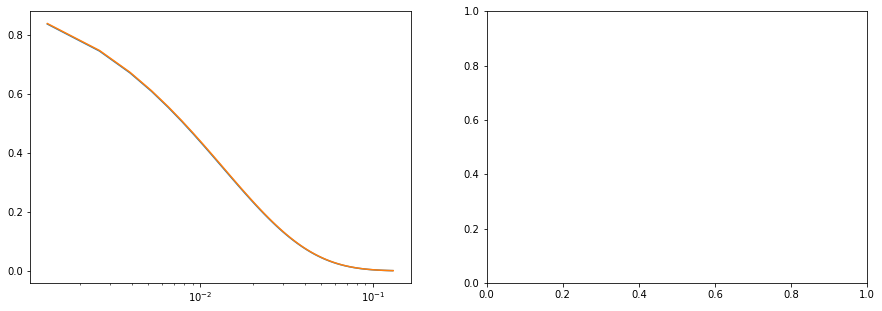

In [12]:
np.set_printoptions(8)
import glob
import numpy as np
import os.path
import math
import matplotlib.pyplot as plt
%matplotlib inline

L=5
f=1.0208582
Ns=[753,756]
Ns=[756,756]
actualA = [25.1282,25.2217]
actualA = [25.2217,25.2217]

kaf=100
#patterns1 = ['/home/chew/outputdata/keff/2D/newkfac{}_N{}_L{}_50tm/*'.format(kaf,Ns[1],L)]
patterns1 = ['/home/chew/outputdata/keff/2D/orikfac{}_N{}_L{}_50tm_1.0208582rm/*'.format(kaf,Ns[0],L),
             '/home/chew/outputdata/keff/2D/newkfac{}_N{}_L{}_50tm/*'.format(kaf,Ns[1],L)]
#tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr100N423A42_3799.csv',delimiter=',').T
#tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr100N753A25_2393.csv',delimiter=',').T
#tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr100N756A25_2217.csv',delimiter=',').T

def err(a,b):
    return (a-b)*100/a
    #return (a-b)
out=[]
fig,ax=plt.subplots(1,2,figsize=(15,5))

for i,pattern in enumerate(patterns1):
    #tth = TTH[i]
    #Sth = STH[i]
    N=Ns[i]
    Area=actualA[i]
    conc = N/Area    
    print(pattern)
    print('N{},Area{}'.format(N,Area))
    fns = glob.glob(pattern)
    #fns=fns[:20000]
    kts = []
    ss=[]
    ds = 1
    cnter = 0
    for fn in fns:
        r=np.loadtxt(fn,delimiter=',')
        y=np.array(r).T[1][::ds]
        s=y/float(N)   
        ss.append(s)
        cnter+=1
    x=np.array(r).T[0][::ds]
    s=np.mean(np.array(ss),axis=0)
    x=x[1:]
    s=s[1:]
    name=pattern[:-2]+'_meanst'
    print(name)
    filename=open(name,'w')
    np.savetxt(name,[x,s],delimiter=',',fmt='%s')
    filename.close()       
    print(len(fns),len(x))
    #plt.loglog(x,mkt)
    ax[0].semilogx(x,s,'-',label=str(i))
    #print(x[-5:])
    #out.append(s)
    #plt.errorbar(x,mkt,sd)
    #print(x[-5:],tth[-5:])
    #diff = err(s,Sth)
    #diff = s-Sth
    #ax[1].semilogx(tth,diff,label=str(i))
    #ax[0].semilogx(tth,Sth,'r')
#ax[0].set_xlim(0.1,0.14)
#ax[0].set_ylim(0.0005,0.002)
#ax[0].set_ylabel('S(t)')
#ax[1].set_ylabel('difference, %')
#ax[1].grid(True)
#print(s[-1])
#ts = x
#ax[1].legend()
#ax[0].legend()

In [35]:
from scipy.integrate import cumtrapz
kaf=100
R=0.01
D=1
ka=kaf*D*4*pi
f=1.0208582
Ns=756
actualA=25.2217

g=0.577216;
f = 1.0208582;
Pa=1./(1+(3)**0.5*(math.log(f*f/12)+(4*pi*D/ka)-2*g)/2/pi);
l=f*R
tdl = l*l/4/D
conc = Ns/actualA

In [127]:
names = ['/home/chew/outputdata/keff/2D/orikfac100_N756_L5_50tm_1.0208582rm_meanst',
        '/home/chew/outputdata/keff/2D/newkfac100_N756_L5_50tm_meanst']

TT = []
SS = []
SE=[]
subd=10000
for name in names:
    T,S = np.loadtxt(name,delimiter=',')
    TT.append(T)
    SS.append(S)
    dt = (T[1]-T[0])/subd
    tmax = T[-1]
    tt = np.arange(dt,tmax+dt,dt)
    t= tt[subd-1::subd]
    if abs(t[-1]-T[-1])>1e-8: print('wrong last time')    
    kte = np.array([invlt(ka,R,D,t) for t in tt])
    Sthe = np.exp(-conc*dt*cumtrapz(kte,initial=0))[subd-1::subd]
    SE.append(Sthe)
    #tth = tt[(subd-1)::subd]

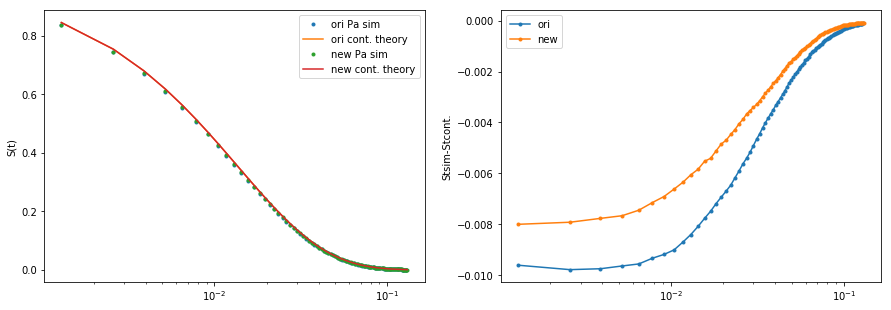

In [128]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

padef = ['ori','new']
for i in range(2):
    ax[0].semilogx(TT[i],SS[i],'.',label=padef[i]+' Pa sim')
    ax[0].semilogx(TT[i],SE[i],'-',label=padef[i]+' cont. theory')
    oridiff = SS[i]-SE[i]
    ax[1].semilogx(TT[i],oridiff,'.-',label=padef[i])
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Stsim-Stcont.')
ax[0].legend()
ax[1].legend()

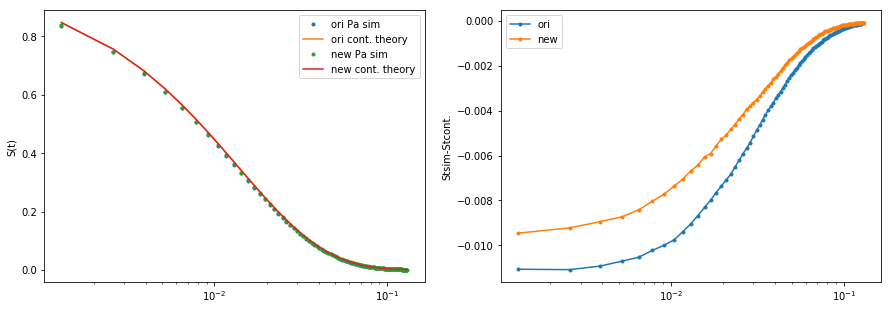

In [115]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

padef = ['ori','new']
for i in range(2):
    ax[0].semilogx(TT[i],SS[i],'.',label=padef[i]+' Pa sim')
    ax[0].semilogx(TT[i],SE[i],'-',label=padef[i]+' cont. theory')
    oridiff = SS[i]-SE[i]
    ax[1].semilogx(TT[i],oridiff,'.-',label=padef[i])
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Stsim-Stcont.')
ax[0].legend()
ax[1].legend()

new Pa 91.72793663882513


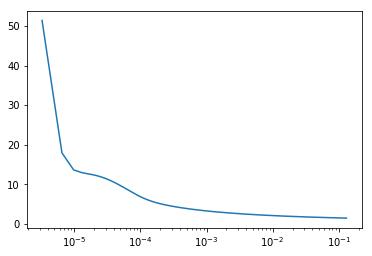

In [151]:
names = ['/home/chew/outputdata/keff/2D/newkfac100_N756_L5_50tm_meanst']

TT = []
SS = []
SL=[]
subd=400#10000
g=0.577216;
f = 1.0208582;
l=f*R
tdl = l*l/4/D

for i,name in enumerate(names):
    i=1
    if i==0:
        Pa=ka/2/math.sqrt(3)/D
        print('ori Pa',Pa)
    else:
        Pa=1./(1+(3)**0.5*(math.log(f*f/12)+(4*pi*D/ka)-2*g)/2/pi);
        print('new Pa',Pa)
    T,S = np.loadtxt(name,delimiter=',')
    TT.append(T)
    SS.append(S)
    dt = (T[1]-T[0])/subd
    tmax = T[-1]
    ttt = np.arange(dt,tmax+dt,dt)
    t= ttt[subd-1::subd]
    if abs(t[-1]-T[-1])>1e-8: print('wrong last time')
    ktl = np.array([invltL(t,D,Pa,td,ka) for t in ttt])
    #SthL = np.exp(-conc*dt*cumtrapz(ktL,initial=0))[subd-1::subd]
    #SL.append(SthL)
    #tth = tt[(subd-1)::subd]
plt.semilogx(ttt,ktl)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
padef = ['ori','new']
for i in range(2):
    ax[0].semilogx(TT[i],SS[i],'.',label=padef[i]+' Pa sim')
    ax[0].semilogx(TT[i],SL[i],'-',label=padef[i]+' lattice theory')
    oridiff = SS[i]-SL[i]
    ax[1].semilogx(TT[i],oridiff,'.-',label=padef[i])
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Stsim-Stlattice.')
ax[0].legend()
ax[1].legend()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(1.4986881268640597, 3)

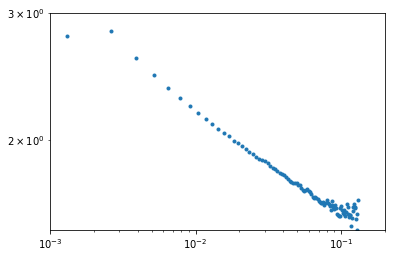

In [175]:
g = 0.577216
def func(t,C1,C2): #lattice kt for long time
    b1=4*D/C2/C2
    A=np.log(b1*t)+4*pi*D/C1-2*g
    return 4*pi*D*(1/A-g/A**2+(g**2-np.pi**2/6)/A**3+0.25/A**4)

#plt.loglog(tt,ktL,'-')
T,S = np.loadtxt(names[0],delimiter=',')
Ns=756
actualA=25.2217
conc = Ns/actualA
ktsim = calk(S,T,conc)
plt.loglog(T,ktsim,'.')
plt.xlim(1e-3,0.2)
plt.ylim(0,3)
#plt.semilogx(T,func(T,ka,R),'r--')
#plt.semilogx(ttt,ktl,'g--')
#name = '/home/chew/outputdata/keff/2D/newkfac100_ktlattice'
#filename=open(name,'w')
#np.savetxt(name,[tt,ktL],delimiter=',',fmt='%s')
#filename.close()      

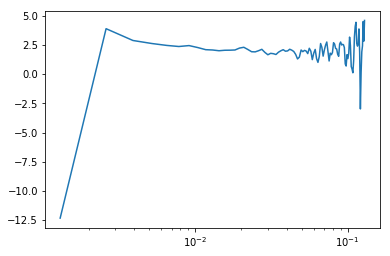

In [149]:
diff=(ktsim-ktL[subd-1::subd][:-1])*100/ktsim
plt.semilogx(T,diff)

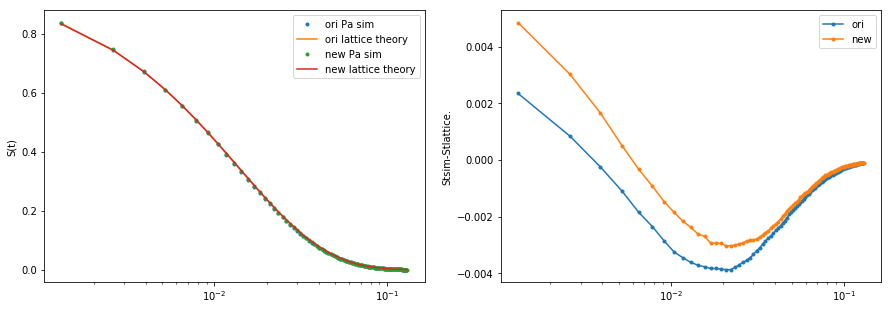

In [130]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
padef = ['ori','new']
for i in range(2):
    ax[0].semilogx(TT[i],SS[i],'.',label=padef[i]+' Pa sim')
    ax[0].semilogx(TT[i],SL[i],'-',label=padef[i]+' lattice theory')
    oridiff = SS[i]-SL[i]
    ax[1].semilogx(TT[i],oridiff,'.-',label=padef[i])
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Stsim-Stlattice.')
ax[0].legend()
ax[1].legend()

/home/chew/outputdata/keff/2D/orikfac0.01_N423_L6.5_50tm_1.0208582rm/*
N423,Area42.3799
[1.29747857 1.29878126 1.30008395 1.30138664 1.30268933]
[1.29747857 1.29878126 1.30008395 1.30138664 1.30268933]
/home/chew/outputdata/keff/2D/orikfac0.01_N423_L6.5_50tm_1.0208582rm_meankt_test
1000
10000
/home/chew/outputdata/keff/2D/newkfac0.01_N423_L6.5_50tm_1.0208582rm/*
N423,Area42.3799
[1.29747857 1.29878126 1.30008395 1.30138664 1.30268933]
[1.29747857 1.29878126 1.30008395 1.30138664 1.30268933]
/home/chew/outputdata/keff/2D/newkfac0.01_N423_L6.5_50tm_1.0208582rm_meankt_test
1000
10000


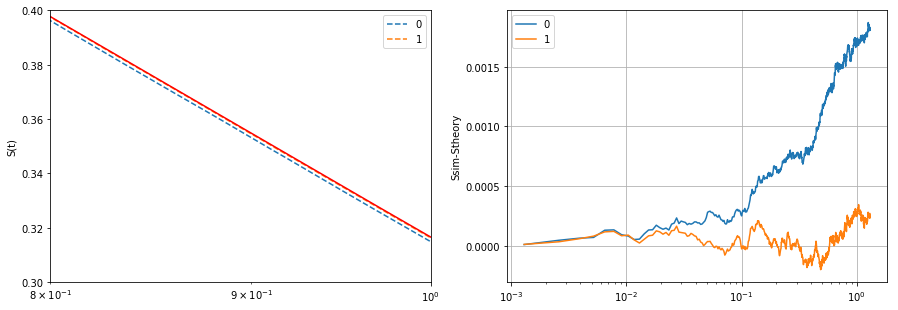

In [91]:
kaf=0.01
L=6.5
f=1.0208582
Ns=[423,423]
#conc=10#10,30,80
actualA=[42.3799,42.3799]

patterns3 = ['/home/chew/outputdata/keff/2D/orikfac{}_N{}_L{}_50tm_{}rm/*'.format(kaf,Ns[1],L,f),
             '/home/chew/outputdata/keff/2D/newkfac{}_N{}_L{}_50tm_{}rm/*'.format(kaf,Ns[1],L,f)]

tth,Sth = np.loadtxt('/home/chew/outputdata/2Dirr0.01N423A42_3799.csv',delimiter=',').T
tth = tth[99::100]
Sth = Sth[99::100]

def err(a,b):
    #return abs(a-b)*100/a
    return (a-b)

out=[]
fig,ax=plt.subplots(1,2,figsize=(15,5))
for i,pattern in enumerate(patterns3):
    N=Ns[i]
    Area=actualA[i]
    conc = N/Area    
    print(pattern)
    print('N{},Area{}'.format(N,Area))
    fns = glob.glob(pattern)
    fns=fns[:10000]
    kts = []
    ss=[]
    ds = 1
    cnter = 0
    for fn in fns:
        r=np.loadtxt(fn,delimiter=',')
        y=np.array(r).T[1][::ds]
        s=y/float(N)   
        #ss+=s
        ss.append(s)
        cnter+=1
        #ss.append(s)
        #kt = calk(s,x,conc)           
        #kts.append(kt)
    x=np.array(r).T[0][::ds]
    #s=np.mean(ss,axis=0)
    s=np.mean(np.array(ss),axis=0)
    #sm=np.sum(np.array(ss),axis=0)
    #nonzero = np.count_nonzero(np.array(ss),axis=0) 
    #s = sm/nonzero    
    #s=ss/cnter
    #mkt=calk(s,x,conc)[1:]
    x=x[1:]
    s=s[1:]
    print(x[-5:])  
    print(tth[-5:])       
    #mkt = np.mean(kts,axis=0)[1:]
    #sd = np.std(kts,axis=0)[1:]
    name=pattern[:-2]+'_meankt_test'
    print(name)
    print(len(x))
    #filename=open(name,'w')
    #np.savetxt(name,[x,mkt],delimiter=',',fmt='%s')
    #filename.close()       
    print(len(fns))
    #plt.loglog(x,mkt)
    ax[0].semilogx(x,s,'--',label=str(i))
    #print(x[-5:])
    #out.append(s)
    #plt.errorbar(x,mkt,sd)
    #print(x[:5],x[0]-x[1],x[-1]/(x[0]-x[1]),x[-1])
    diff = err(Sth,s)
    #diff = Sth-s
    ax[1].semilogx(tth,diff,label=str(i))
ax[0].set_xlim(0.8,1)
ax[0].set_ylim(0.3,0.4)
ax[0].set_ylabel('S(t)')
ax[1].set_ylabel('Ssim-Stheory')
ax[0].semilogx(tth,Sth,'r')
ax[1].grid(True)
#print(s[-1])
ts = x
ax[1].legend()
ax[0].legend()

In [401]:
xx,t1


(array([0.01      , 0.01000003, 0.01000005, ..., 0.02499995, 0.02499998,
        0.025     ]),
 array([0.00130269, 0.00260538, 0.00390807, 0.00521076, 0.00651345,
        0.00781614, 0.00911883, 0.01042151, 0.0117242 , 0.01302689,
        0.01432958, 0.01563227, 0.01693496, 0.01823765, 0.01954034,
        0.02084303, 0.02214572, 0.02344841, 0.0247511 , 0.02605379,
        0.02735648, 0.02865917, 0.02996185, 0.03126454, 0.03256723,
        0.03386992, 0.03517261, 0.0364753 , 0.03777799, 0.03908068,
        0.04038337, 0.04168606, 0.04298875, 0.04429144, 0.04559413,
        0.04689682, 0.04819951, 0.04950219, 0.05080488, 0.05210757,
        0.05341026, 0.05471295, 0.05601564, 0.05731833, 0.05862102,
        0.05992371, 0.0612264 , 0.06252909, 0.06383178, 0.06513447,
        0.06643716, 0.06773985, 0.06904253, 0.07034522, 0.07164791,
        0.0729506 , 0.07425329, 0.07555598, 0.07685867, 0.07816136,
        0.07946405, 0.08076674, 0.08206943, 0.08337212, 0.08467481,
        0.0859775 , 0

756.0 100 0.130268933063405
(100, 99)
/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst_periodic


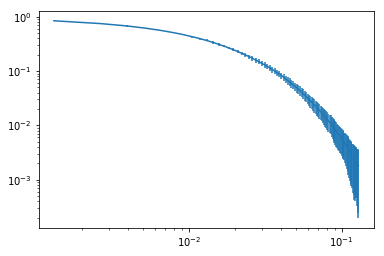

In [391]:
pattern = '/home/chew/spatiocyte_example/2D/output/*'
fns = glob.glob(pattern)
ss=[]
cnter = 0
for fn in fns:
    t,nt=np.array(np.loadtxt(fn,delimiter=',',skiprows=1)).T
    N0 = nt[0]    
    nt=nt[1:-1]
    #s=nt/float(N0)   
    ss.append(nt)
    cnter+=1
print(N0,cnter,t[-1])
t=t[1:-1]
print(np.array(ss).shape)
s=np.mean(np.array(ss),axis=0)/N0
std=np.std(np.array(ss),axis=0)/N0
name=pattern[:-8]+'ec3_newPa_simkf100_N756_L5_50tm_meanst_periodic'
print(name)
#plt.semilogx(t,s,'.')
plt.errorbar(t,s,std)
plt.xscale('log')
plt.yscale('log')
filename=open(name,'w')
np.savetxt(name,[t,s],delimiter=',',fmt='%s')
filename.close()            

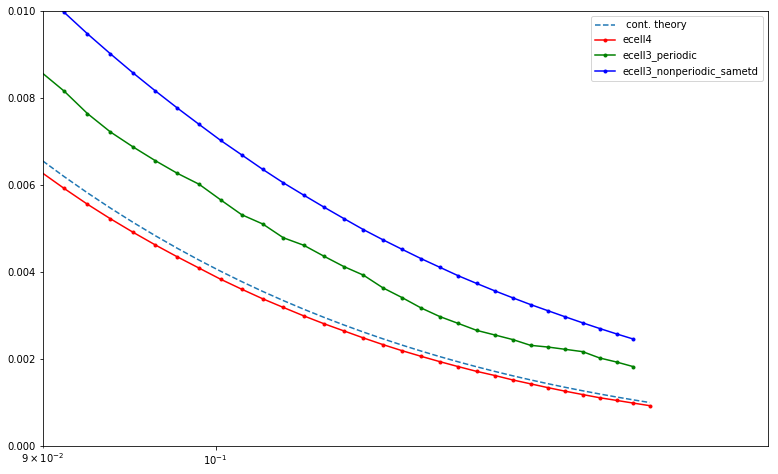

In [397]:
fig,ax=plt.subplots(1,1,figsize=(13,8))
plt.semilogx(t1,SE[1],'--',label=' cont. theory')

e4 = '/home/chew/outputdata/keff/2D/newkfac100_N756_L5_50tm_meanst'
t1,st1 = np.loadtxt(e4,delimiter=',')
plt.semilogx(t1,st1,'r.-',label='ecell4')

#e3='/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst'
e3='/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst_periodic'
t2,st2 = np.loadtxt(e3,delimiter=',')
plt.semilogx(t2,st2,'g.-',label='ecell3_periodic')

#ea='/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst_nonperiodic'
#ta,sta = np.loadtxt(ea,delimiter=',')
#plt.semilogx(ta,sta,'c.-',label='ecell3_nonperiodic')

#eb = '/home/chew/outputdata/keff/2D/ecell3'
#tb,ntb = np.array(np.loadtxt(eb,delimiter=',',skiprows=1)).T
#stb = ntb/float(N0)
#plt.semilogx(tb[1:],stb[1:],'y.-',label='ecell3_local')

ec = '/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst_nonperiodic_sametd'
tc,stc = np.loadtxt(ec,delimiter=',')
plt.semilogx(tc,stc,'b.-',label='ecell3_nonperiodic_sametd')



#e='/home/chew/spatiocyte_example/2D/ec3_newPa_simkf100_N756_L5_50tm_meanst_nonperiodic'
#t3,st3 = np.loadtxt(e,delimiter=',')
#plt.semilogx(t3,st3,'c.-',label='ecell3_nonperiodic')
plt.xlim(0.09,0.14)
plt.ylim(0.,0.01)
#plt.ylim(0.5,0.9)
#plt.xlim(0,0.01)
plt.legend()

Area 25.2217 25.0308 25.0121
1256.6370614359173


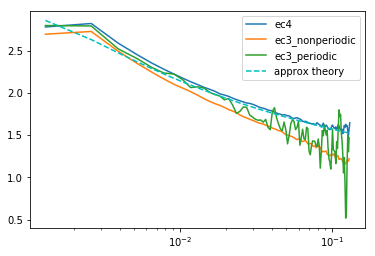

In [399]:
def plotg(N,Area,t,st,name):
    conc = float(N)/Area
    kt = calk(st,t,conc)
    plt.semilogx(t,kt,label=name)

def func(t,C1,C2,D): #lattice kt for long time
    g = 0.577216
    b1=4*D/C2/C2
    A=np.log(b1*t)+4*pi*D/C1-2*g
    return 4*pi*D*(1/A-g/A**2+(g**2-np.pi**2/6)/A**3+0.25/A**4)

N=756
Area1=25.2217 
plotg(N,Area1,t1,st1,'ec4')
    
Area2=25.0308 #ec3 non per b.
plotg(N,Area2,tc,stc,'ec3_nonperiodic')

Area3 = 25.0121 #(periodic boundary ec3)
plotg(N,Area3,t2,st2,'ec3_periodic')

print('Area',Area1,Area2,Area3)

kaf=100
R=0.01
D=1
ka=kaf*D*4*pi
print(ka)

plt.semilogx(t2,func(t2,ka,R,D),'c--',label='approx theory')
plt.legend()

In [381]:
756*2*100/277340

0.5451792024230186

In [328]:
83*10/60

13.833333333333334